In [1]:
!python -V

Python 3.9.7


In [2]:
 import sys
 print(sys.executable) 

/home/ubuntu/anaconda3/envs/myenv/bin/python


In [3]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [4]:
import mlflow
mlflow.set_tracking_uri("sqlite:///taxiexperiment.db")
mlflow.set_experiment('taxiexperiment')

<Experiment: artifact_location='/home/ubuntu/mlops-zoomcamp/02-experiment-tracking/notebooks/mlruns/1', creation_time=1724030520416, experiment_id='1', last_update_time=1724030520416, lifecycle_stage='active', name='taxiexperiment', tags={'developer': 'rosaav'}>

In [5]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [6]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

/tmp/ipykernel_2420/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2420/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


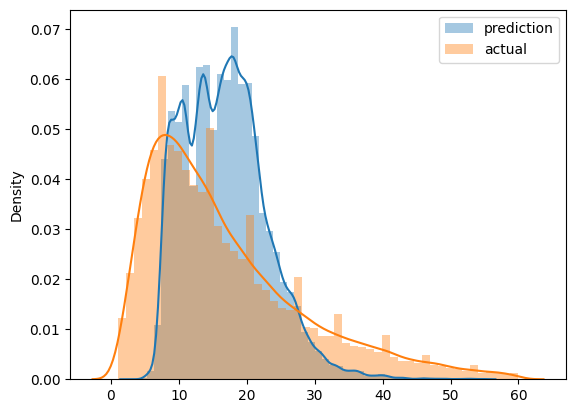

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715200888857

/tmp/ipykernel_2420/2000010712.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='prediction')
/tmp/ipykernel_2420/2000010712.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='actual')


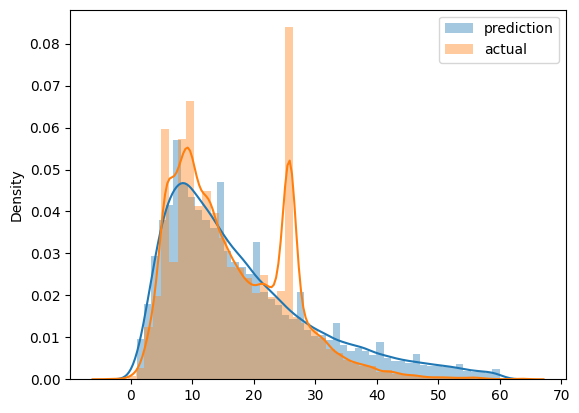

In [16]:
sns.distplot(y_val, label='prediction')
sns.distplot(y_pred, label='actual')

plt.legend()

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    mlflow.set_experiment_tag('developer', 'rosaav')
    mlflow.log_param("train-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
    mlflow.log_param("val-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
    
    alpha = 1
    mlflow.log_param('alpha', alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)

/tmp/ipykernel_2420/2000010712.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='prediction')
/tmp/ipykernel_2420/2000010712.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='actual')


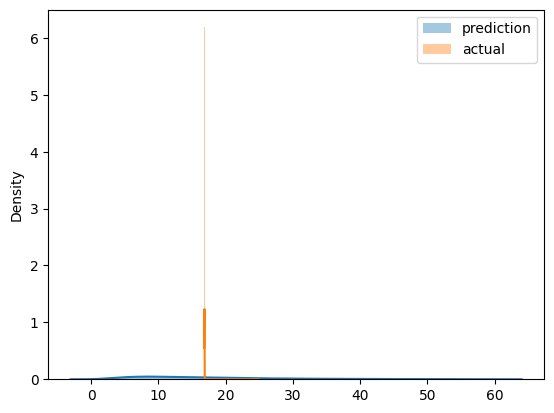

In [19]:
sns.distplot(y_val, label='prediction')
sns.distplot(y_pred, label='actual')

plt.legend()

### Bayesian Optimization and tracker

In [20]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [25]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [27]:
best_params = {
    "learning_rate": 0.05801885008959241,
    "max_depth": 67,
    "min_child_weight": 1.0626768285721733,
    "objective": "reg:linear",
    "reg_alpha": 0.01657080052448372,
    "reg_lambda": 0.01201948250013855,
    "seed": 42,
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=best_params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/08/23 04:44:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/08/23 04:44:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '52590877a3da4d469d438fd7e71defb0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:44:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.73815
[1]	validation-rmse:11.29843
[2]	validation-rmse:10.89160
[3]	validation-rmse:10.51661
[4]	validation-rmse:10.16971
[5]	validation-rmse:9.85206
[6]	validation-rmse:9.55931
[7]	validation-rmse:9.29075
[8]	validation-rmse:9.04381
[9]	validation-rmse:8.81599
[10]	validation-rmse:8.60893
[11]	validation-rmse:8.41978
[12]	validation-rmse:8.24732
[13]	validation-rmse:8.08797
[14]	validation-rmse:7.94514
[15]	validation-rmse:7.81335
[16]	validation-rmse:7.69423
[17]	validation-rmse:7.58578
[18]	validation-rmse:7.48756
[19]	validation-rmse:7.39710
[20]	validation-rmse:7.31520
[21]	validation-rmse:7.24144
[22]	validation-rmse:7.17404
[23]	validation-rmse:7.11254
[24]	validation-rmse:7.05687
[25]	validation-rmse:7.00603
[26]	validation-rmse:6.95995
[27]	validation-rmse:6.91804
[28]	validation-rmse:6.87947
[29]	validation-rmse:6.84429
[30]	validation-rmse:6.81233
[31]	validation-rmse:6.78348
[32]	validation-rmse:6.75777
[33]	validation-rmse:6.73311
[34]	validation-rms

[277]	validation-rmse:6.36672
[278]	validation-rmse:6.36667
[279]	validation-rmse:6.36652
[280]	validation-rmse:6.36617
[281]	validation-rmse:6.36610
[282]	validation-rmse:6.36595
[283]	validation-rmse:6.36583
[284]	validation-rmse:6.36568
[285]	validation-rmse:6.36562
[286]	validation-rmse:6.36556
[287]	validation-rmse:6.36505
[288]	validation-rmse:6.36487
[289]	validation-rmse:6.36458
[290]	validation-rmse:6.36432
[291]	validation-rmse:6.36428
[292]	validation-rmse:6.36409
[293]	validation-rmse:6.36393
[294]	validation-rmse:6.36365
[295]	validation-rmse:6.36342
[296]	validation-rmse:6.36331
[297]	validation-rmse:6.36301
[298]	validation-rmse:6.36275
[299]	validation-rmse:6.36260
[300]	validation-rmse:6.36241
[301]	validation-rmse:6.36226
[302]	validation-rmse:6.36211
[303]	validation-rmse:6.36180
[304]	validation-rmse:6.36175
[305]	validation-rmse:6.36165
[306]	validation-rmse:6.36150
[307]	validation-rmse:6.36128
[308]	validation-rmse:6.36116
[309]	validation-rmse:6.36114
[310]	vali

[551]	validation-rmse:6.33229
[552]	validation-rmse:6.33212
[553]	validation-rmse:6.33199
[554]	validation-rmse:6.33191
[555]	validation-rmse:6.33188
[556]	validation-rmse:6.33193
[557]	validation-rmse:6.33187
[558]	validation-rmse:6.33186
[559]	validation-rmse:6.33181
[560]	validation-rmse:6.33174
[561]	validation-rmse:6.33167
[562]	validation-rmse:6.33159
[563]	validation-rmse:6.33148
[564]	validation-rmse:6.33145
[565]	validation-rmse:6.33123
[566]	validation-rmse:6.33122
[567]	validation-rmse:6.33120
[568]	validation-rmse:6.33124
[569]	validation-rmse:6.33117
[570]	validation-rmse:6.33086
[571]	validation-rmse:6.33089
[572]	validation-rmse:6.33080
[573]	validation-rmse:6.33072
[574]	validation-rmse:6.33068
[575]	validation-rmse:6.33060
[576]	validation-rmse:6.33051
[577]	validation-rmse:6.33045
[578]	validation-rmse:6.33042
[579]	validation-rmse:6.33035
[580]	validation-rmse:6.33025
[581]	validation-rmse:6.33021
[582]	validation-rmse:6.33009
[583]	validation-rmse:6.33010
[584]	vali

[825]	validation-rmse:6.31878
[826]	validation-rmse:6.31874
[827]	validation-rmse:6.31873
[828]	validation-rmse:6.31868
[829]	validation-rmse:6.31856
[830]	validation-rmse:6.31860
[831]	validation-rmse:6.31861
[832]	validation-rmse:6.31856
[833]	validation-rmse:6.31858
[834]	validation-rmse:6.31856
[835]	validation-rmse:6.31844
[836]	validation-rmse:6.31851
[837]	validation-rmse:6.31843
[838]	validation-rmse:6.31841
[839]	validation-rmse:6.31842
[840]	validation-rmse:6.31841
[841]	validation-rmse:6.31840
[842]	validation-rmse:6.31823
[843]	validation-rmse:6.31821
[844]	validation-rmse:6.31814
[845]	validation-rmse:6.31813
[846]	validation-rmse:6.31822
[847]	validation-rmse:6.31816
[848]	validation-rmse:6.31824
[849]	validation-rmse:6.31827
[850]	validation-rmse:6.31825
[851]	validation-rmse:6.31825
[852]	validation-rmse:6.31818
[853]	validation-rmse:6.31812
[854]	validation-rmse:6.31815
[855]	validation-rmse:6.31816
[856]	validation-rmse:6.31815
[857]	validation-rmse:6.31810
[858]	vali

2024/08/23 04:49:09 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/08/23 04:49:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:49:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2024/08/23 04:49:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)